In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/ml-100k")
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
# 导入user_df和item_df
user_df = pd.read_csv("./user_df.csv")
user_df = user_df.iloc[:,1:]
user_df.index += 1
item_df = pd.read_csv("./item_df.csv")
item_df = item_df.iloc[:,1:]
item_df.index += 1
user_df.head()

,age,gender,occupation
1,2,9,29
2,5,8,23
3,2,9,30
4,2,9,29
5,3,8,23


In [ ]:
item_df.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,30,31,32,34,35,36,36,37,38,39,40,41,42,43,44,45,46,47,48
2,30,32,33,33,34,35,36,37,38,39,40,41,42,43,44,45,47,47,48
3,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,47,48
4,30,32,32,33,34,36,36,37,39,39,40,41,42,43,44,45,46,47,48
5,30,31,32,33,34,35,37,37,39,39,40,41,42,43,44,45,47,47,48


In [ ]:
# 导入序列数据
sequential_df = pd.read_csv("./sequential_df.csv")
sequential_df = sequential_df.iloc[:,1:]

In [ ]:
data = sequential_df
data

,rating,user_id,item_id,timestamp,item_id_last1,item_id_last2,item_id_last3,item_id_last4,item_id_last5
0,1,1,196,874965677,166,156,165,172,168
1,1,1,187,874965678,196,166,156,165,172
2,1,1,250,874965706,187,196,166,156,165
3,1,1,127,874965706,250,187,196,166,156
4,1,1,14,874965706,127,250,187,196,166
...,...,...,...,...,...,...,...,...,...
95280,0,943,450,888693158,229,449,840,151,1330
95281,0,943,230,888693158,450,229,449,840,151
95282,0,943,228,888693158,230,450,229,449,840
95283,0,943,227,888693158,228,230,450,229,449


In [ ]:
import numpy as np

# 设置随机数生成器的种子
np.random.seed(0)
# 创建一个1到10000的数组
arr = np.arange(data.shape[0])
# 原地随机排列数组
np.random.shuffle(arr)
# 选择百分之多少的数据作为训练集
train_test_ratio = 0.9
# 打乱后的数组的前百分之train_test_ratio(i.e.90%)作为训练集对应的index
train_index = arr[:int(len(arr)*train_test_ratio)]
# 打乱后的数组的后百分之(1-train_test_ratio)(i.e.10%)作为测试集对应的index
test_index = arr[int(len(arr)*train_test_ratio):]
# 获取训练集和测试集
train_set = data.iloc[train_index,:]
test_set = data.iloc[test_index, :]

# 将训练集和测试集的每一行都变成一个元组，方便后续处理
train_set = [tuple(row) for row in train_set.itertuples(index=False, name=None)]
test_set = [tuple(row) for row in test_set.itertuples(index=False, name=None)]

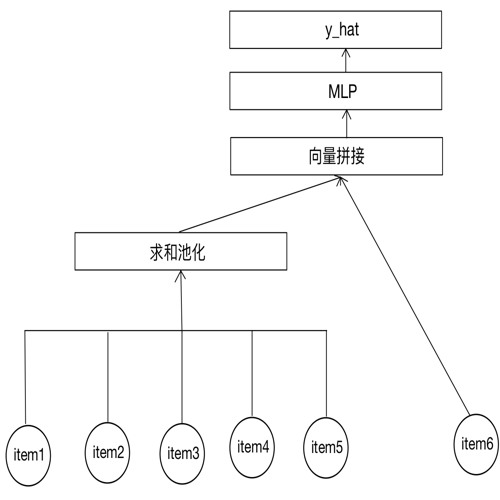

In [ ]:
from PIL import Image
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/图片")
image_path = "./seq_base.jpeg"
image = Image.open(image_path)
new_size = (500, 500)
resized_image = image.resize(new_size)
# 红色点表示：商品id，蓝色点表示：商铺id，白色点表示：其他id
resized_image

In [ ]:
class DIN_without_attention(nn.Module):
    def __init__(self, num_features, hidden_dims):
        super(DIN_without_attention, self).__init__()

        # 嵌入层
        self.embeddings = nn.Embedding(num_features, hidden_dims)

        # 神经网络层
        self.mlp = nn.Sequential(nn.Linear(2*hidden_dims, 1),
                                 nn.Tanh())

    def forward(self, x, hist_item):
      '''
      x: 待预测的item
      hist_item: 用户在x之前看过的前5个item
      '''
      # x的shape为(batch_size)
      # embedded_x的shape为(batch_size, hidden_dims)
      embedded_x = self.embeddings(x)
      # hist_item的shape为(batch_size, seq_len, hidden_dims)
      embedded_hist_item = self.embeddings(hist_item)
      # 做求和池化，即将所有的embedded_hist_item求和
      # sumpooling_embedded_hist_item的shape为(batch_size, hidden_dims)
      sumpooling_embedded_hist_item = torch.sum(embedded_hist_item, axis = 1)
      # 将sumpooling_embedded_hist_item和embedded_x进行拼接
      # concat_embbedded的shape为(batch_size, hidden_dims * 2)
      concat_embbedded = torch.cat([sumpooling_embedded_hist_item, embedded_x], axis = 1)
      # 将concat_embbedded送入MLP层
      # out的shape为(batch_size, 1)
      out = self.mlp(concat_embbedded)
      # out的shape为(batch_size)
      out = torch.squeeze(out)
      # logit的shape为(batch_size)
      logit = torch.sigmoid(out)
      return logit

In [ ]:
def evaluation(y_pred, y_true):
  p = precision_score(y_true, y_pred)
  r = recall_score(y_true, y_pred)
  acc = accuracy_score(y_true,y_pred)
  return p,r,acc

In [ ]:
num_features, hidden_dims = 3000, 32
model = DIN_without_attention(num_features, hidden_dims)

In [ ]:
# 实例化损失函数和优化器
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score,recall_score,accuracy_score
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
  for rating, user_id, item_id, timestamp, item1, item2, item3, item4, item5 \
                      in DataLoader(train_set, batch_size=512, shuffle=True):

    item1, item2, item3, item4, item5 = torch.unsqueeze(item1,1), \
                                        torch.unsqueeze(item2,1), \
                                        torch.unsqueeze(item3,1), \
                                        torch.unsqueeze(item4,1), \
                                        torch.unsqueeze(item5,1)
    # item的shape为(batch_size, 过去item个数)
    item = torch.concat([item1, item2, item3, item4, item5],axis = 1)

    # 清空梯度
    optimizer.zero_grad()
    # 前向传播
    predictions = model(item_id, item)
    # 计算损失
    loss = loss_fn(predictions, rating.float())
    # 反向传播
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")

  # 训练集
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = rating.detach().numpy()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('train: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))


  #测试集
  item = torch.tensor(test_set)[:,-5:]
  item_id = torch.tensor(test_set)[:,2]
  predictions = model(item_id, item)
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = torch.tensor(test_set)[:,0].detach().float()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('test: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))

  print('----------------------------------------------------------------------------------------')

Epoch 0, Loss: 0.6133525371551514
train: Precision 0.7042 | Recall 0.7194 | accuracy 0.6786
test: Precision 0.6833 | Recall 0.7408 | accuracy 0.6609
----------------------------------------------------------------------------------------
Epoch 1, Loss: 0.6242716908454895
train: Precision 0.6582 | Recall 0.7482 | accuracy 0.6468
test: Precision 0.6820 | Recall 0.7525 | accuracy 0.6633
----------------------------------------------------------------------------------------
Epoch 2, Loss: 0.6203675866127014
train: Precision 0.6901 | Recall 0.7424 | accuracy 0.6905
test: Precision 0.6809 | Recall 0.7460 | accuracy 0.6603
----------------------------------------------------------------------------------------
Epoch 3, Loss: 0.660523533821106
train: Precision 0.6228 | Recall 0.7482 | accuracy 0.6111
test: Precision 0.6760 | Recall 0.7458 | accuracy 0.6558
----------------------------------------------------------------------------------------
Epoch 4, Loss: 0.622542142868042
train: Precision